<header style="background-color: rgb(0, 62, 92); color: white; margin-top: 20px; padding:28px; ">
  <img src="images/Xlogo.png" alt="Transposition of a vector" title="Vector transposition" width="115" style="float: left;">
  <p style=" text-align: center; font-size: 32px;">   
   <strong> Deep Learning in Finance MAP548 </strong></p>
  <p style=" text-align: center; font-size: 25px;"><strong> Project 1 -  Deep pricing and calibration </strong></p>
  <p style=" text-align: center; font-size: 20px;"> Eduardo Abi Jaber </p>
</header>

# <font color='red'>PLEASE ENTER YOUR FULL NAMES HERE:</font>



- MANSARD Diane
- POTTIER Clément

<font color='red'>**DEADLINE: March 2 (5:00 pm)**</font>

<font color='red'>**PLease send both pdf ipynb files with name : Name1_Name2_Project1**</font>

# The two factor Bergomi model

The two factor Bergomi Model (L Bergomi, 2005) under the risk-neutral filtered probability space $(\Omega, \mathcal F,(\mathcal F_t)_{t\geq 0}, \mathbb Q )$  has the following dynamics:


\begin{equation}
  \begin{aligned}
    dS_t &= S_t\sqrt{V_t}dB_t, \quad S_0>0;\\
    X_t &= X_t^1 + X_t^2,\\
    V_t &= \xi \exp{\left(X_t-\frac{1}{2} \mathbb{V}[X_t] \right)},\\
      X_t^i &=  \eta_i\int_0^t e^{-\kappa_i(t-s)} dW_s,
  \end{aligned}
  \end{equation}

where $ B=\rho W + \sqrt{1-\rho^2} W^{\perp}$ with $(W,W^{\perp})$ a two-dimensional Brownian motion, $\rho \in [-1,1]$.

$X_t^i$ is a Ornstein–Uhlenbeck (Gaussian) process such that $X_t^i \sim \mathcal{N}(0, \eta_i^2\frac{(1-e^{-2\kappa_i t})}{2\kappa_i})$. Note that both $X^1$ and $X^2$ are driven by the same Brownian motion.

Recall $\mathbb V[(X+Y)] = \mathbb V[X] + \mathbb V[Y] + 2\mathbb {COV}[X,Y]$.

In addition, we fix $\kappa_2=2.6$, thus there are in total five calibratable model parameters: $(\xi, \kappa_1, \eta_1, \eta_2, \rho)$.

We are interested in computing the price of European style contingent claims, with payoff $g(S_T)$ for some function $g$:
$$
C_t = \mathbb{E} \left[g(S_T) \vert \mathcal F_t) \right].
$$

For European vanilla call options, with $g(x) = (x-K)^{+}$ with strike $K$; no closed form formula to compute $g(S_T)$

Suggested range of model parameters for training:

$\xi \in [0.03,0.25], \kappa_1 \in [10,60], \eta_1 \in [5,35],\eta_2 \in [1,5],\rho \in [-0.9,-0.1]$

# Your task

Inspired by the deep pricer for the one factor Bergomi model. Implement a deep pricer for the two factor Bergomi model. You have to generate your own training set using a scheme of your choice that you have to detail (use the fixed grid for strikes and maturities below).

Once your NN is trained, showcase the train and test error, and perform a calibration on the market implied volatility surface that was used in the one factor Bergomi and comment. 

Also provide/display the output prices of the NN of the set of parameters set 1, 2 and 3 below. 

You have to provide a notebook that compiles, together with the trained weights of your Neural Networks that we can load with the command: *model_iv.load_weights('2FBergomiNNWeights.h5')*. 

(!) The actual training of NN is not difficult, the difficult part is to get good data (and lots of it), so be careful about your simulation schemes (training might require a larger dataset than for 1 factor bergomi).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

## Let's start simulating Xt1 and Xt2 using a recursive method

Define the process for a 1-factor model:

$$
\widetilde X_t = e^{\kappa t}X_t = \int_0^t e^{\kappa s} dW_s,
$$

so that

$$
\widetilde X_{t_{j+1}} = \widetilde X_{t_j} + \int_{t_{j}}^{t_{j+1}}e^{\kappa s} dW_s =  \
    \widetilde X_{t_j}+\sqrt{\frac{e^{2 \kappa t_{j+1}}-e^{2 \kappa t_{j}}}{2\kappa}}Y_j,
$$

with $t_0 = 0, \quad t_N = T, \quad Y_i  \sim \mathcal{N}(0, 1)$ iid. Thus we first simulate $\widetilde X_{t_{j+1}}$ and then convert back to $X_t$ by:

$$
 X_t = e^{-\kappa t} \widetilde X_t.
$$

We then finally multiply by the corresponding eta to get the final value of the process for each Xt.

In [2]:
xi, kappa_1, eta_1, eta_2, rho, = 0.14, 35, 20, 3, -0.5
kappa_2 = 2.6
T = 2
n_steps = 1000 # number of time steps
N_sims = 50 # number of simulations

dt = T/n_steps
tt = np.linspace(0., T, n_steps + 1)

In [3]:
# Liste des valeurs à rechercher
times_to_find = [0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ]

# Dictionnaire pour stocker les indices
indices = {time: np.where(tt == time)[0] for time in times_to_find}

# Afficher les indices
for time, index in indices.items():
    print(f"Time interval of {time}:", f"index {index} of the matrix tt")

Time interval of 0.1: index [50] of the matrix tt
Time interval of 0.3: index [150] of the matrix tt
Time interval of 0.6: index [300] of the matrix tt
Time interval of 0.9: index [450] of the matrix tt
Time interval of 1.2: index [600] of the matrix tt
Time interval of 1.5: index [750] of the matrix tt
Time interval of 1.8: index [900] of the matrix tt
Time interval of 2.0: index [1000] of the matrix tt


In [4]:
np.random.seed(42)

def gen_bm_path(n_steps,N_sims):
    w1 = np.random.normal(0, 1, (n_steps, N_sims))
    return w1

w1 = gen_bm_path(n_steps,N_sims)

In [5]:
# Simulation of Xt1
exp1_Xt1 = np.exp(kappa_1*tt[1:])
exp2_Xt1 = np.exp(2*kappa_1*tt)

diff_exp2_Xt1 = np.diff(exp2_Xt1)
std_vec_Xt1 = np.sqrt(diff_exp2_Xt1/(2*kappa_1))[:,np.newaxis] #to be broadcasted columnwise 
exp1_Xt1 = exp1_Xt1[:,np.newaxis]
Xt1 = np.concatenate((np.zeros(w1.shape[1])[np.newaxis, :],(1/exp1_Xt1)*np.cumsum(std_vec_Xt1*w1, axis = 0)))
Xt1 = eta_1*Xt1

In [6]:
# Simulation of Xt2
exp1_Xt2 = np.exp(kappa_2*tt[1:])
exp2_Xt2 = np.exp(2*kappa_2*tt)

diff_exp2_Xt2 = np.diff(exp2_Xt2)
std_vec_Xt2 = np.sqrt(diff_exp2_Xt2/(2*kappa_2))[:,np.newaxis] #to be broadcasted columnwise 
exp1_Xt2 = exp1_Xt2[:,np.newaxis]
Xt2 = np.concatenate((np.zeros(w1.shape[1])[np.newaxis, :],(1/exp1_Xt2)*np.cumsum(std_vec_Xt2*w1, axis = 0)))
Xt2 = eta_2*Xt2

In [7]:
# Creation of Xt
Xt = Xt1 + Xt2

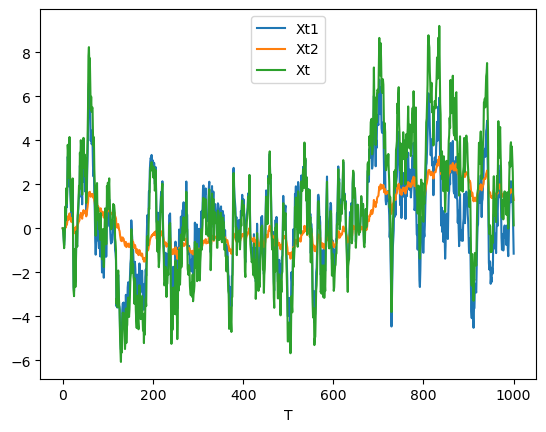

In [8]:
i_ind = 1
plt.plot(Xt1[:,i_ind],label='Xt1')
plt.plot(Xt2[:,i_ind],label='Xt2')
plt.plot(Xt[:,i_ind],label='Xt')
plt.xlabel('T')
plt.legend()
plt.show()

## Simulation of Vt and St with fixed parameters

In [9]:
Vt = xi * np.exp(Xt - 0.5 * np.var(Xt))

<span style="color:red">Ok de juste prendre la variance de Xt ? Le prof a donné des éléments plus détaillés pour la compo de la variance.</span>

In [10]:
S0 = 100
np.random.seed(48)
w2 = gen_bm_path(n_steps,N_sims)

In [11]:
log_S = np.ones(N_sims).reshape(1,-1)*np.log(S0)
epochs_iter_j = tqdm(range(n_steps), desc="iteration", miniters=2000)
for j in epochs_iter_j:
    log_S_next = log_S[j]-0.5*Vt[j]*dt+np.sqrt(Vt[j]*dt)*\
        (rho*w2[j]+np.sqrt(1-rho**2)*w2[j])
    log_S=np.append(log_S,log_S_next.reshape(1,-1),axis=0)

S = np.exp(log_S)

iteration:   0%|          | 0/1000 [00:00<?, ?it/s]

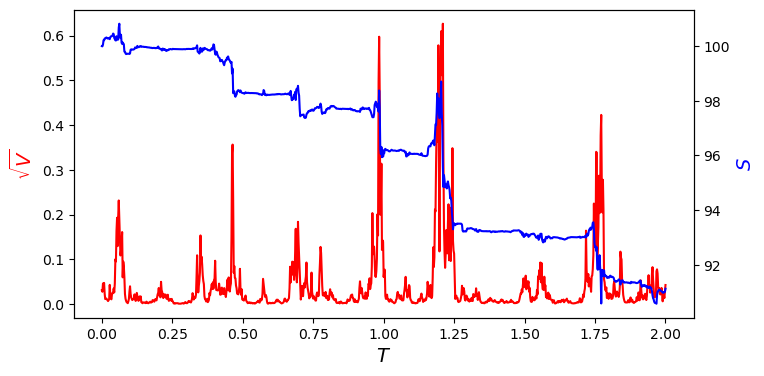

In [12]:
i_ind = 4 # The 4-th simulation
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()
ax2 = ax.twinx()
lns2 = ax2.plot(tt,np.array(S[:,i_ind]), '-b',label = r'$S$')
lns1 = ax.plot(tt,np.sqrt(Vt[:,i_ind]), 'r',ls='-', label = r'$\sqrt{V}$')
labs = [l.get_label() for l in lns2+lns1]
ax.set_xlabel(r"$T$",size=14)
ax.set_ylabel(r'$\sqrt{V}$', color='red',size=14)
ax2.set_ylabel(r'$S$', color='blue',size=14)
plt.show()

## Let's now compute the prices of the option with the Monte Carlo method

With K=100 and T=2, the option price is:

In [13]:
K = 100
price = np.mean(np.maximum(S[-1] - K, 0)) #Do the average of the payoffs of all the simulations
print(f"The option payoff is {price:.2f}")

The option payoff is 3.84


With K=100 and the requested time intervals:

In [14]:
for time, index in indices.items():
    price = np.mean(np.maximum(S[index] - K, 0))
    print(f"The option payoff at time {time} is {price:.2f}")

The option payoff at time 0.1 is 0.35
The option payoff at time 0.3 is 1.03
The option payoff at time 0.6 is 2.04
The option payoff at time 0.9 is 2.64
The option payoff at time 1.2 is 3.05
The option payoff at time 1.5 is 2.97
The option payoff at time 1.8 is 3.24
The option payoff at time 2.0 is 3.84


Option prices at different strikes:

In [15]:
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])*S0

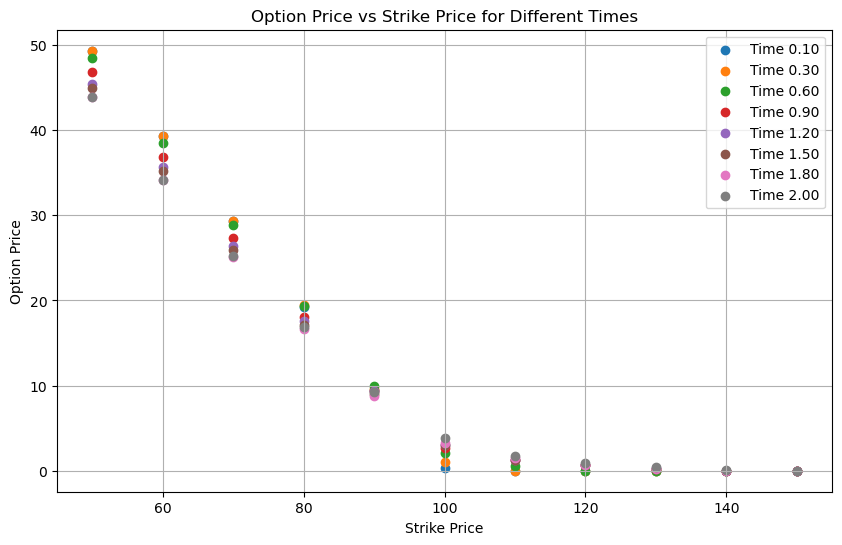

In [16]:
r = 0.02

prices = {}

for time, index in indices.items():
    prices[time] = []
    for strike in strikes:
        price = np.mean(np.maximum(S[index] - strike, 0))
        prices[time].append((strike, price))

# Plot the results
plt.figure(figsize=(10, 6))
for time, prices_data in prices.items():
    strikes, prices_values = zip(*prices_data)
    plt.scatter(strikes, prices_values, label=f'Time {time:.2f}')

plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title('Option Price vs Strike Price for Different Times')
plt.legend()
plt.grid(True)
plt.show()

## Let's implement the result in an array 

In [17]:
parameters = [xi, kappa_1, eta_1, eta_2, rho]
x = np.array(parameters)

x.shape

(5,)

In [18]:
# Extraire tous les deuxièmes éléments de chaque tuple et les stocker dans une liste
values_list = [value[1] for sublist in prices.values() for value in sublist]

# Convertir la liste en un array NumPy
y = np.array(values_list)

y.shape

(88,)

In [19]:
print(y)

[4.92873097e+01 3.92873097e+01 2.92873097e+01 1.92873097e+01
 9.43386458e+00 3.54754489e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.93407144e+01
 3.93407144e+01 2.93407144e+01 1.94195777e+01 9.61957768e+00
 1.02878817e+00 1.92062209e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.84752606e+01 3.84752606e+01
 2.88465215e+01 1.93029266e+01 9.91639566e+00 2.03764939e+00
 5.21611958e-01 8.73170720e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.68000120e+01 3.68370430e+01 2.73778301e+01
 1.80858911e+01 9.39206495e+00 2.64450415e+00 1.26945348e+00
 6.69453479e-01 2.36946000e-01 0.00000000e+00 0.00000000e+00
 4.54804760e+01 3.56893642e+01 2.64295546e+01 1.75652421e+01
 9.32047430e+00 3.05060773e+00 1.31605975e+00 6.90268903e-01
 2.61793756e-01 0.00000000e+00 0.00000000e+00 4.49426514e+01
 3.51708344e+01 2.58883777e+01 1.70906114e+01 8.97815435e+00
 2.96718646e+00 1.30244122e+00 6.34085367e-01 2.25833250e-01
 0.00000000e+00 0.000000

## Let's generate the dataset with moving parameters

<span style="color:red">Reprendre ce qui a été fait au-dessus (dans une fonction?) et le refaire avec une grille de paramètre</span>

In [20]:
# Define the parameters grids
xi_grid = np.random.uniform(0.03, 0.25, N_sims)
kappa_1_grid = np.random.uniform(10, 60, N_sims)
eta_1_grid = np.random.uniform(5, 35, N_sims)
eta_2_grid = np.random.uniform(1, 5, N_sims)
rho_grid = np.random.uniform(-0.9, -0.1, N_sims)

# Sample IV surface values

In [21]:
#based on the grid:
S0 = 100
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])*S0
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

### parameter set 1

$\xi = 0.06, \kappa_1 =41.6, \eta_1 = 18.2428, \eta_2 = 3.43, \rho = -0.7$

### parameter set 2

$\xi = 0.1, \kappa_1 = 15.6, \eta_1 = 5.5857, \eta_2 = 2.2867, \rho = -0.4$

### parameter set 3

$\xi = 0.2, \kappa_1 = 54.6, \eta_1 = 31.3496, \eta_2 = 4.5733, \rho = -0.8$

# References

1)  Lorenzo Bergomi. Smile dynamics II. Risk Magazine, 2005

2) Blanka Horvath, Aitor Muguruza, and Mehdi Tomas. Deep learning volatility: a deep neural 
network perspective on pricing and calibration in (rough) volatility models. Quantitativ 
Finance, 21(1):11–27, 20218

3) Ryan McCrickerd and Mikko S Pakkanen. Turbocharging monte carlo pricing for the rough 
bergomi model. Quantitative Finance, 18(11):1877–1886, 2018